TODO: learned vocab should only be over the vocab in the cipher. in other words
X should be `n words x n letters x n cipher vocab` and $\pi$ should be 
`n cipher vocab x n vocab

# Setup

In [1]:
import string
from cryptogram import vectorize_text

TARGET_ALPHABET = string.ascii_uppercase + ' '
len(TARGET_ALPHABET)

27

# Define Cryptogram

In [4]:
CRYPTOGRAM_BASE = '''
ED KFT JPRN UERVB VPYB DP YC
FDDBRDEPR DKFD IBPIJB PA
FVVPYIJEUKYBRD OFOBJC UFD QFVX FRT
JBD DKERNU KFIIBR DP DKBY DKBC LBRD
PHD FRT KFIIBRBT DP DKERNU
'''

CRYPTOGRAM_BASE = '''
JO CASZUY ESFVPMO SZF OXOKPOC HZD
XSD HOESFO DAOG QFO AQXVOY
'''

CRYPTOGRAM_BASE = '''
D'IK AKVJZ RS MKHYDPK RUHR NSJ OHZ
YDTRKZ RS TDYKZOK HZF YKHMZ LMSG DR.
DR UHT H XJHYDRN HZF H FDGKZTDSZ
HYY DRT SCZ.
'''

CRYPTOGRAM_BASE = '''
HU H ZCYX, USQ SHV WNRQ KN PQXCQFQ
CG KSQ CVQHX RHG — KSQ BYCGWQ NY
JGCZSK NO SQY WSCXVSNNV UKNYCQU. CG
KSQ YQHX ENYXV, SNEQFQY, RQG XCJQ
KSHK UCRBXI VCVG'K QLCUK.
'''

In [5]:
CRYPTOGRAM_BASE = '''
Call me Ishmael. Some years ago - never mind how long precisely - having little or no money in my purse, and nothing particular to interest me on shore, I thought I would sail about a little and see the watery part of the world.
'''.upper()

In [6]:
# There's no reason for the algorithm to prefer the identity permutation,
# so we can send unencrypted text through for debugging purposes
#
# TODO: show how the algorithm does better with more data: i.e. show results
# with first sentence only, etc.
CRYPTOGRAM_BASE = '''
The great ships hung motionless in the air, over every nation on
Earth. Motionless they hung, huge, heavy, steady in the sky, a
blasphemy against nature. Many people went straight into shock
as their minds tried to encompass what they were looking at.
The ships hung in the sky in much the same way that bricks
don't.
'''.upper()

## Preprocess Cryptogram

In [7]:
# basic preprocessing
CRYPTOGRAM = (
    CRYPTOGRAM_BASE
    .upper()
    .translate(
        str.maketrans({c: '' for c in string.punctuation + '—'})
    )
    .split()
)

# split into ngrams
CRYPTOGRAM = [
    w1 + ' ' + w2
    for w1, w2 in zip(CRYPTOGRAM[:-1], CRYPTOGRAM[1:])
]

## Load ngram frequencies

*Prerequisite*: Run `google-books-ngrams-download.ipynb`.

In [8]:
from collections import defaultdict


# this is used to prevent loading ngrams which could not possibly
# match a single ngrams in the cryptogram

def word_group(w):
    word_sequence = tuple([
        len(set(w[:i]))
        for
        i in range(len(w))
    ])
    return word_sequence, w.index(' ')

search_space = set()
for word in CRYPTOGRAM:
    search_space.add(word_group(word))
list(search_space)[:5]

[((0, 1, 2, 3, 4, 5, 6, 6), 5),
 ((0, 1, 2, 3, 4, 5), 2),
 ((0, 1, 2, 3, 4, 5, 6, 7, 7, 8, 8, 9, 9), 8),
 ((0, 1, 2, 3, 4, 5, 6), 3),
 ((0, 1, 2, 3, 3, 4, 4, 5, 6, 6, 7), 6)]

In [9]:
import glob
import pandas as pd


def load_ngrams(f):
    df = pd.read_csv(f)
    df['word_group'] = df.ngram.str.strip().apply(word_group)
    return df[df.word_group.apply(search_space.__contains__)]

frequencies = pd.concat((load_ngrams(f) for f in glob.glob('ngrams/*-clean.csv.gz')))
frequencies.shape

(661823, 3)

In [10]:
frequencies.head()

,ngram,occurrences,word_group
15,AB drawn,3,"((0, 1, 2, 3, 4, 5, 6, 7), 2)"
18,ABC a,21,"((0, 1, 2, 3, 4), 3)"
21,ABE WE,1,"((0, 1, 2, 3, 4, 5), 3)"
22,ABE have,2,"((0, 1, 2, 3, 4, 5, 6, 7), 3)"
23,ABED is,2,"((0, 1, 2, 3, 4, 5, 6), 4)"


In [11]:
# just for efficiency
frequencies = frequencies[frequencies.occurrences.gt(20)]
frequencies.shape

(201925, 3)

In [12]:
import numpy as np

frequencies['word'] = frequencies.ngram.str.strip().str.upper()
frequencies['log_likelihood'] = (
    np.log10(frequencies.occurrences)
    # _important_: The denominator is the sum of all occurrences within each word group
    # _not_ over all bigrams.
    - np.log10(frequencies.word_group.map(frequencies.groupby('word_group').occurrences.sum()))
)

In [13]:
frequencies.groupby('word_group').log_likelihood.max()

word_group
((0, 1, 2, 2, 3, 4, 5, 6, 7, 7, 7, 7, 8, 9), 7)                   -0.322414
((0, 1, 2, 2, 3, 4, 5, 6, 7, 8), 7)                               -0.601018
((0, 1, 2, 2, 3, 4, 5, 6, 7, 8, 9, 10), 5)                        -0.368303
((0, 1, 2, 3, 3, 4), 2)                                           -0.111438
((0, 1, 2, 3, 3, 4, 4, 5, 6, 6, 7), 6)                            -0.421169
((0, 1, 2, 3, 3, 4, 5, 6, 6, 7, 8, 9), 4)                         -0.705112
((0, 1, 2, 3, 3, 4, 5, 6, 7, 8, 9), 4)                            -0.851659
((0, 1, 2, 3, 4), 3)                                              -0.585370
((0, 1, 2, 3, 4, 4, 5, 5, 6, 7), 5)                               -0.957788
((0, 1, 2, 3, 4, 4, 5, 6, 7, 8, 8, 9, 9), 10)                     -0.296986
((0, 1, 2, 3, 4, 4, 5, 6, 7, 8, 8, 9, 9, 10, 10), 10)             -0.287689
((0, 1, 2, 3, 4, 4, 5, 6, 7, 8, 9), 1)                            -0.820374
((0, 1, 2, 3, 4, 5), 2)                                           -0.243344
(

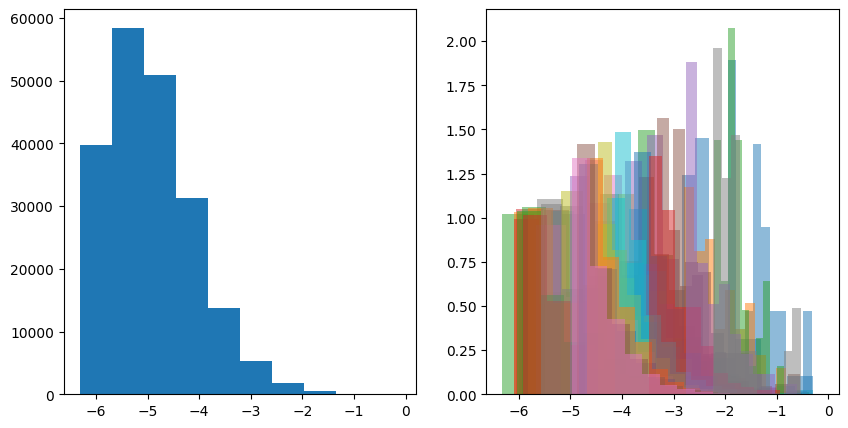

In [14]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].hist(frequencies.log_likelihood)
for _, group in frequencies.groupby('word_group'):
    axs[1].hist(group.log_likelihood, alpha=.5, density=True)

## Vectorize

Encode the text as one-hot arrays with shape `(n words, n characters, alphabet)`

In [15]:
X = vectorize_text(CRYPTOGRAM, TARGET_ALPHABET)
V = vectorize_text(frequencies.word.tolist(), TARGET_ALPHABET)
X.shape, V.shape

((56, 17, 27), (201925, 17, 27))

In [16]:
# It's possible that X has words of length not found in the dictionary
# (but not the other way around due to how the dictionary is loaded).
# 
# If this is the case we pad the values so the matrix math doesn't blow
# up and the masking takes care of the rest.
V = np.pad(V, ((0, 0), (0, X.shape[1]-V.shape[1]), (0, 0)))
V.shape

(201925, 17, 27)

# Get Masks

In [17]:
def get_shared_word_separater_mask(text1, text2):
    separater_pos1 = np.array([w.index(' ') for w in text1])
    separater_pos2 = np.array([w.index(' ') for w in text2])
    return separater_pos1[:, None] == separater_pos2[None, :]

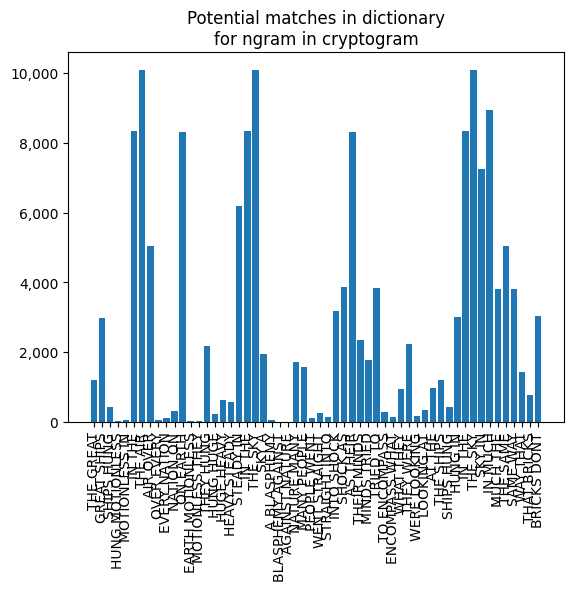

In [18]:
import matplotlib.pyplot as plt

from cryptogram import get_shared_word_length_mask, get_shared_token_sequence_mask


fig, ax = plt.subplots()

mask = (
    get_shared_word_length_mask(CRYPTOGRAM, frequencies.word.tolist())
    * get_shared_token_sequence_mask(X, V)
    * get_shared_word_separater_mask(CRYPTOGRAM, frequencies.word.tolist())
)
ax.bar(np.arange(mask.shape[0]), mask.sum(axis=1))

ax.set_title('Potential matches in dictionary\nfor ngram in cryptogram')
_ = ax.set_xticks(np.arange(mask.shape[0]), CRYPTOGRAM, rotation=90)
ax.yaxis.set_major_formatter('{x:,.0f}')

# Random Scores

In [19]:
from cryptogram import word_vector_overlap


F = frequencies.log_likelihood.values
def score(π, X, V, F, mask):
    Xt = X @ π
    matches = word_vector_overlap(torch.log(Xt+1e-24), V)
    return (matches*mask + F[None, :]*mask)

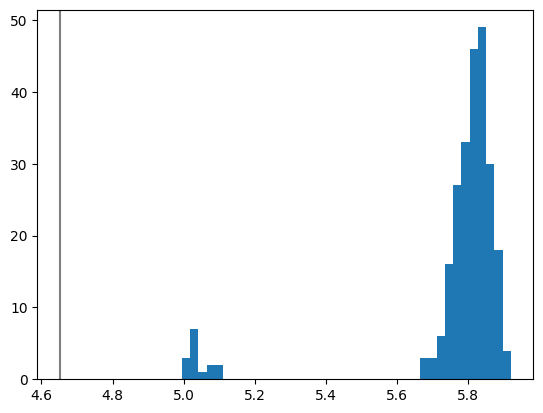

In [20]:
import matplotlib.pyplot as plt
import torch


# this is only helpful if we know the original mapping

fig, ax = plt.subplots()

random_scores = []
for _ in range(250):
    π = np.eye(len(TARGET_ALPHABET))
    np.random.shuffle(π)
    random_scores.append(
        -score(*[
            torch.from_numpy(a)
            for a in (π, X, V, F, mask)
        ]).mean()
    )
ax.hist(random_scores, bins=40)

π = np.eye(len(TARGET_ALPHABET))
true_score = -score(*[
    torch.from_numpy(a)
    for a in (π, X, V, F, mask)
]).mean()
ax.axvline(true_score, color='C7')

# pytorch

In [21]:
import torch

X = torch.from_numpy(X)
V = torch.from_numpy(V)
F = torch.from_numpy(F)
mask = torch.from_numpy(mask).type(torch.float64)

$$
\begin{align}
P(w^{\prime\vert\pi}) &= \sum_{w}^{}{P(w^{\prime}\vert \pi,w)P(w)}\\
&=\sum_{w}^{}{w^{\prime}\pi^{T}w P(w)}
\end{align}
$$

In [22]:
def score(π, X, V, mask):
    Xt = X @ π
    matches = word_vector_overlap(torch.log(Xt+1e-24), V)
    return (matches + F[None, :])*mask

def make_π(σ):
    # https://www.math.uci.edu/~jxin/AutoShuffleNet_KDD2020F.pdf
    π = torch.exp(σ)
    for _ in range(3):
        for axis in [0, 1]:
            π = π / π.sum(axis=axis, keepdims=True)
    return π

σ = torch.randn(len(TARGET_ALPHABET), len(TARGET_ALPHABET), dtype=torch.float64, requires_grad=True)
π = make_π(σ)
π.sum(axis=0), π.sum(axis=1), π.shape

(tensor([0.9996, 1.0002, 0.9999, 0.9999, 1.0002, 1.0002, 1.0000, 1.0000, 0.9999,
         0.9999, 0.9999, 1.0002, 1.0008, 0.9999, 1.0000, 0.9996, 0.9997, 0.9998,
         1.0002, 0.9999, 1.0000, 1.0002, 0.9999, 0.9999, 1.0002, 1.0002, 0.9998],
        dtype=torch.float64, grad_fn=<SumBackward1>),
 tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
         1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000],
        dtype=torch.float64, grad_fn=<SumBackward1>),
 torch.Size([27, 27]))

In [23]:
optimizer = torch.optim.Adam([σ])
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.001
    maximize: False
    weight_decay: 0
)

In [24]:
from tqdm.notebook import tqdm

def doubly_stochastic_constraint(π):
    return sum(
        (1 - π.sum(axis=axis)).abs().sum()
        for axis in [0, 1]
    )

last_loss = np.inf
with tqdm(range(200000)) as pbar:
    for _ in pbar:
        π = make_π(σ)
        loss = (
            -score(π, X, V, mask).mean()
            + doubly_stochastic_constraint(π)
        )
        loss.retain_grad()
        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        loss = loss.item()
        pbar.set_postfix(loss=f'{loss:>7f}')
        if abs(last_loss - loss) < 1e-8:
            break
        last_loss = loss

  0%|          | 0/200000 [00:00<?, ?it/s]

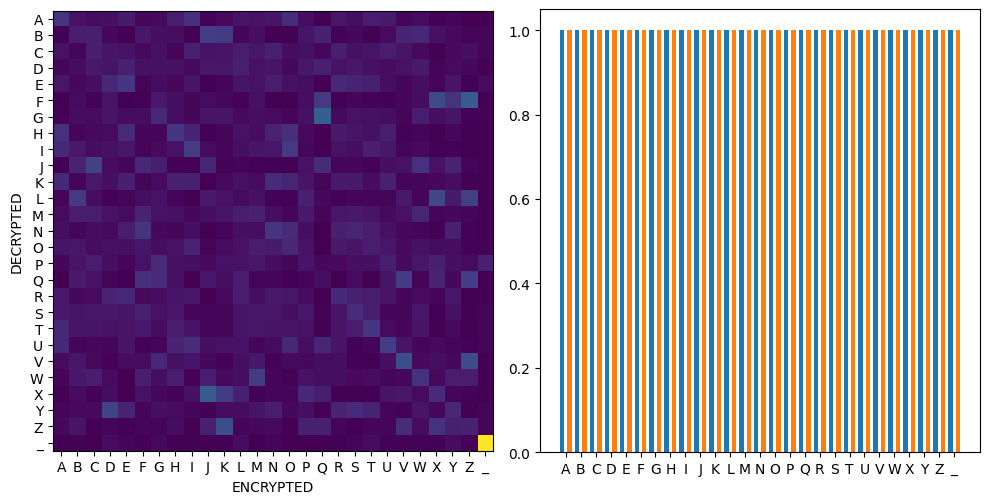

In [25]:
import matplotlib.pyplot as plt


fig, axs = plt.subplots(1, 2, figsize=(10, 5))

π = make_π(σ)
π_max = π.detach().numpy()
axs[0].imshow(π_max)
_ = axs[0].set_xticks(np.arange(len(TARGET_ALPHABET)), TARGET_ALPHABET.replace(' ', '_'))
_ = axs[0].set_yticks(np.arange(len(TARGET_ALPHABET)), TARGET_ALPHABET.replace(' ', '_'))

axs[0].set_xlabel('ENCRYPTED')
axs[0].set_ylabel('DECRYPTED')

axs[1].bar(np.arange(π_max.shape[0])-.25, π_max.sum(axis=1), width=.3)
axs[1].bar(np.arange(π_max.shape[1])+.25, π_max.sum(axis=0), width=.3)
_ = axs[1].set_xticks(np.arange(len(TARGET_ALPHABET)), TARGET_ALPHABET.replace(' ', '_'))

fig.tight_layout()

# Heuristic: Solve for the cipher

1. For each ngram, find the most likely corresponding ngram in the dictionary
2. Over each pair from above, sum the frequencies that a given character in the cryptogram mapped to a given character in the target alphabet.
3. Use these frequencies as the costs in a [linear assignment](https://en.wikipedia.org/wiki/Assignment_problem) to solve key to the cipher

In [26]:
# masked values become 0, which overtake the actual values we're looking for in `argmax`
scores = np.ma.masked_equal(score(π_max, X, V, mask).numpy(), 0.0, copy=False)

translations = []
for w, top_ix in zip(CRYPTOGRAM, np.argsort(-scores, axis=1)[:, :3]):
    for ix in top_ix:
        for w1, t1 in zip(w.split(), frequencies.word.iloc[ix].split()):
            for c1, c2 in zip(w1, t1):
                if np.ma.is_masked(s := scores[CRYPTOGRAM.index(w), ix]):
                    # some words don't have 3 possible matches
                    continue
                translations.append((c1, c2, 1))
translations = pd.DataFrame(translations, columns=['encrypted', 'decrypted', 'likelihood'])
translation_frequencies = translations.groupby(['encrypted', 'decrypted']).likelihood.sum()
translation_frequencies

encrypted  decrypted
A          A            78
           C             2
           E             3
           F             1
           H             2
                        ..
Y          N             3
           R             2
           S             9
           T             2
           Y            27
Name: likelihood, Length: 232, dtype: int64

In [27]:
from scipy.optimize import linear_sum_assignment

C = translation_frequencies.unstack('decrypted').fillna(0)
C = C.reindex(list(TARGET_ALPHABET)).reindex(list(TARGET_ALPHABET), axis=1).fillna(0)
learned_cipher = {
    TARGET_ALPHABET[i]: TARGET_ALPHABET[j]
    for i, j in zip(*linear_sum_assignment(C, maximize=True))
}
learned_cipher

{'A': 'A',
 'B': 'B',
 'C': 'C',
 'D': 'D',
 'E': 'E',
 'F': 'Q',
 'G': 'G',
 'H': 'H',
 'I': 'I',
 'J': 'F',
 'K': 'K',
 'L': 'L',
 'M': 'M',
 'N': 'N',
 'O': 'O',
 'P': 'P',
 'Q': 'J',
 'R': 'R',
 'S': 'S',
 'T': 'T',
 'U': 'U',
 'V': 'V',
 'W': 'W',
 'X': 'X',
 'Y': 'Y',
 'Z': 'Z',
 ' ': ' '}

In [28]:
CRYPTOGRAM_BASE.translate(str.maketrans(learned_cipher)).strip()

"THE GREAT SHIPS HUNG MOTIONLESS IN THE AIR, OVER EVERY NATION ON\nEARTH. MOTIONLESS THEY HUNG, HUGE, HEAVY, STEADY IN THE SKY, A\nBLASPHEMY AGAINST NATURE. MANY PEOPLE WENT STRAIGHT INTO SHOCK\nAS THEIR MINDS TRIED TO ENCOMPASS WHAT THEY WERE LOOKING AT.\nTHE SHIPS HUNG IN THE SKY IN MUCH THE SAME WAY THAT BRICKS\nDON'T."